In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle

import sys
sys.path.insert(0,'../src/')

from utils import *
from multiply_connected_pipe import *
from pipe_system import PipeSystem
from abstract_pipe import *

In [2]:
# with open('pipes_and_shifts.pickle','rb') as f:
#     pipes, shifts = pickle.load(f)
with open('v0.pickle','rb') as f:
    pipes_and_shifts = pickle.load(f)
    pipes = [p for p,_ in pipes_and_shifts]
    shifts = [s for _,s in pipes_and_shifts]
    
with open('global_built.pickle', 'rb') as f:
    global_pipe = pickle.load(f)
 

In [3]:
for pipe in set(pipes):
    for p in pipe.panels:
            p._build()
    pipe.build_pressure_drops()
    pipe.build_plotting_data(density=5)

/home/haiy/pkg/fmm2d/python/fmm2dpy/fmm2d.py:894: ComplexWarning: Casting complex values to real discards the imaginary part
  out.pottarg,out.gradtarg,out.ier = lfmm.cfmm2d_t_d_g(eps,sources,dipstr,targets)


This pressure drop shouldn't be corrected at all!!!

In [4]:
for p in global_pipe.panels: p._build()
global_pipe.build_pressure_drops()

In [5]:
bdr_pipe = BoundaryPipe([BoundaryLet(-200,0,0,4,-1),BoundaryLet(248,0,np.pi,4,1)])
real_pipes = [RealPipe(p,shift_x=shift[0],shift_y=shift[1]) for p,shift in zip(pipes,shifts)]
lets = sorted([l for p in real_pipes for l in p.lets], key=lambda l: l.x)

In [6]:
ps = PipeSystem(real_pipes,bdr_pipe)

In [7]:
ps.fluxes = np.linalg.inv(ps.A) @ ps.b

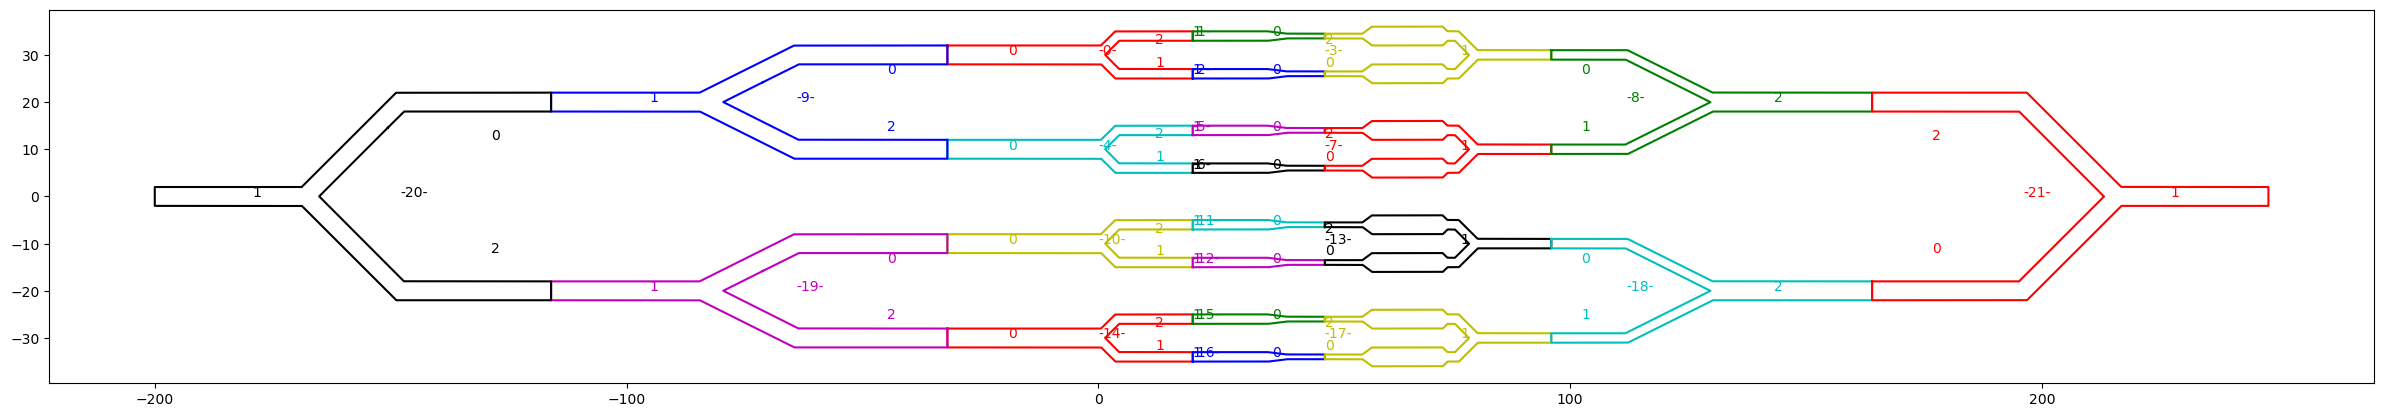

In [8]:
color = 'rgbycmk'*10

fig,ax = plt.subplots(figsize=(30,10))
ax.set_aspect('equal')

for a,i,j,c in zip(range(22),pipes,shifts,color):
    ax.plot(*(i.exterior_boundary.plyg_bdr() + j).T,c=c)
    for k,let in enumerate(i.lets):
        ax.text(*(0.6*let.matching_pt + j),f'{k}',color=c)
    ax.text(*j,f'-{a}-',color=c)

In [9]:
ps.fluxes_of_pipe(19)

array([-0.5 ,  0.25])

In [10]:
xs, ys, u_field, v_field, p_field, o_field = ps.plotting_data()

In [11]:
from scipy.interpolate import griddata

def streams(ax,xx,yy,u,v,base_map=False):
    x = np.linspace(xx.min(), xx.max(), 5000)
    y = np.linspace(yy.min(), yy.max(), 5000)

    xi, yi = np.meshgrid(x,y)

    #then, interpolate your data onto this grid:

    px = xx.flatten()
    py = yy.flatten()
    pu = u.flatten()
    pv = v.flatten()
    pspeed = speed.flatten()

    gu = griddata(zip(px,py), pu, (xi,yi))
    gv = griddata(zip(px,py), pv, (xi,yi))
    gspeed = griddata(zip(px,py), pspeed, (xi,yi))

    lw = 6*gspeed/np.nanmax(gspeed)
    #now, you can use x, y, gu, gv and gspeed in streamplot:

    if base_map:
        xx,yy = ax(xx,yy)
        xi,yi = ax(xi,yi)

    ax.contour(xx,yy,speed, colors='k', alpha=0.4)
    ax.plot(xx,yy,'-k',alpha=0.3)
    ax.plot(xx.T,yy.T,'-k',alpha=0.3)
    ax.plot(xi,yi,'-b',alpha=0.1)
    ax.plot(xi.T,yi.T,'-b',alpha=0.1)
    c = ax.streamplot(x,y,gu,gv, density=2,
    linewidth=lw, color=gspeed, cmap=plt.cm.jet)

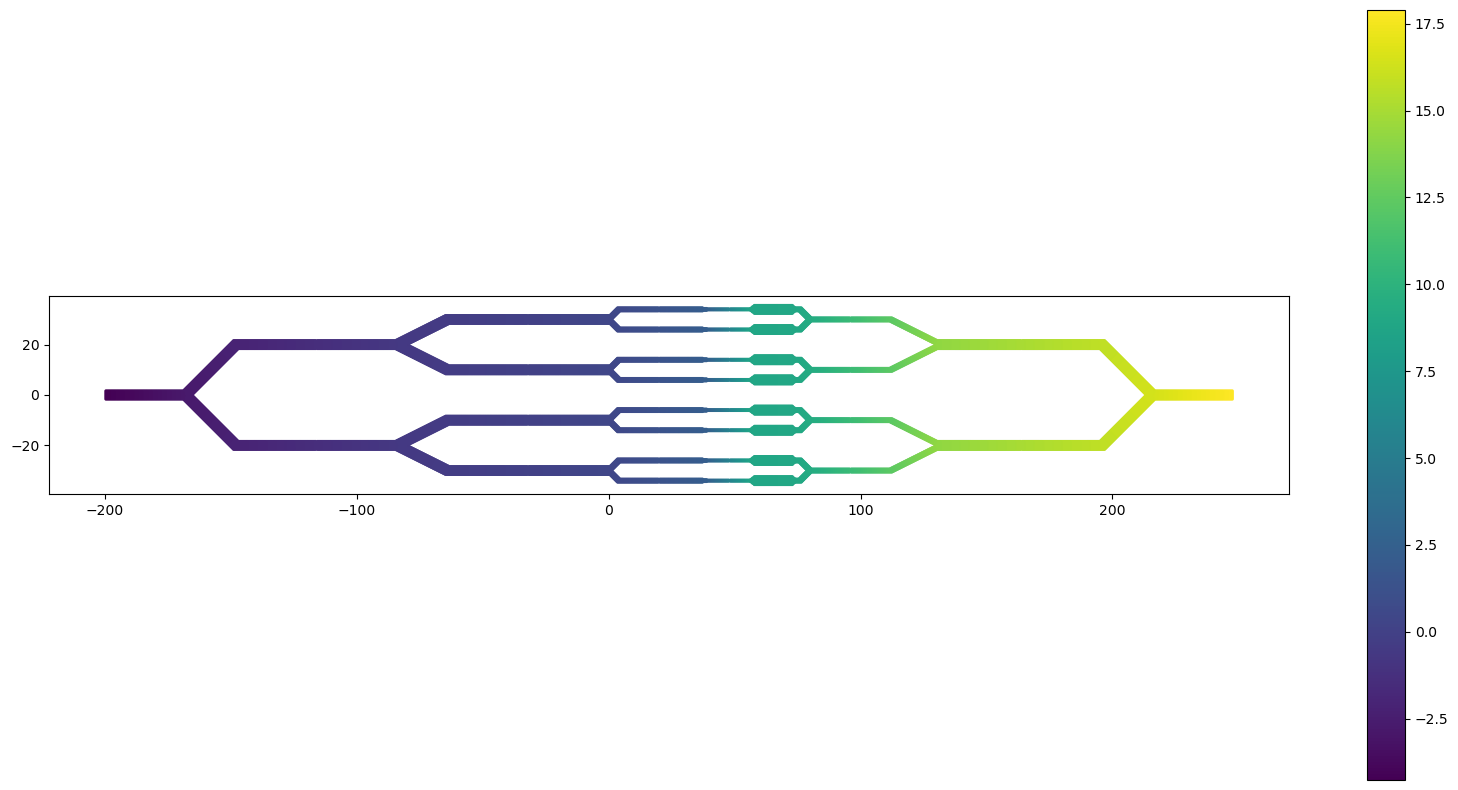

In [12]:
fig, ax = plt.subplots(figsize=(20,10))

ax.set_aspect('equal')
im = ax.scatter(xs,ys,c=p_field,s=0.1)
fig.colorbar(im)

In [13]:
velocity = global_pipe.velocity(xs,ys,global_pipe.omegas[0])

In [14]:
pressure, vorticity = global_pipe.pressure_and_vorticity(xs,ys,global_pipe.omegas[0])

In [15]:
offset = np.quantile(pressure-p_field,.5)

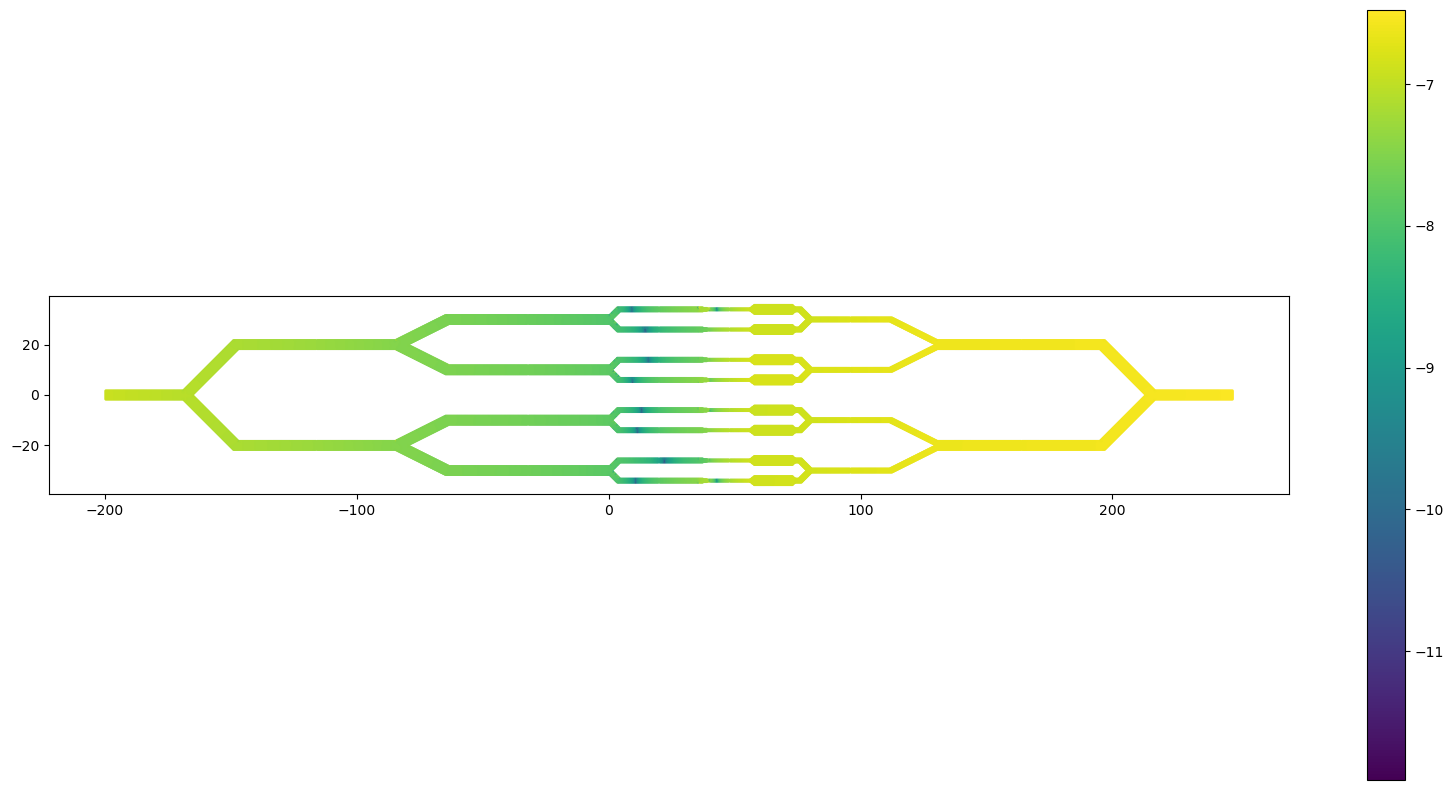

In [16]:
fig, ax = plt.subplots(figsize=(20,10))

ax.set_aspect('equal')
im = ax.scatter(xs,ys,c=np.log10(np.abs(pressure-p_field - offset)),s=0.1)
fig.colorbar(im)

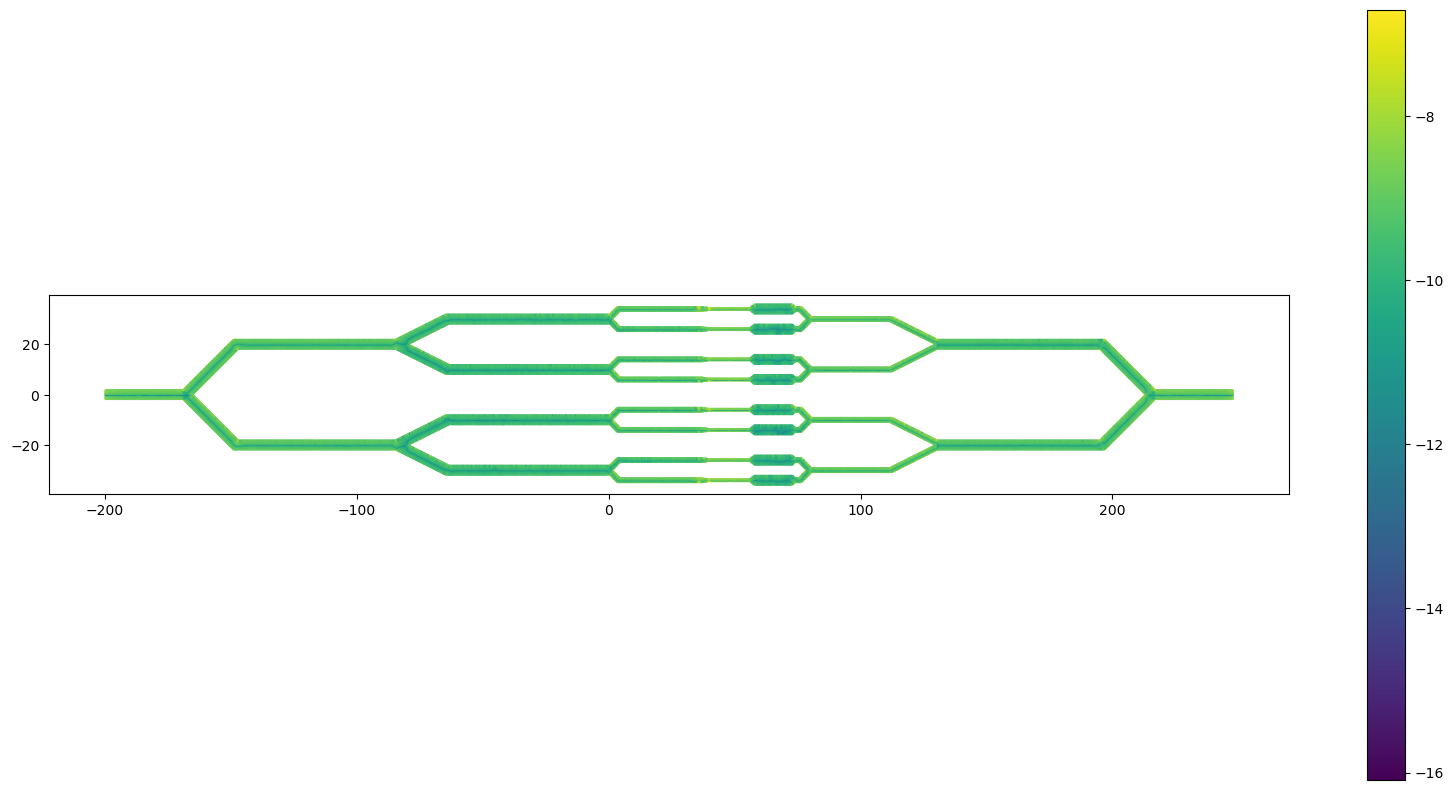

In [17]:
fig, ax = plt.subplots(figsize=(20,10))

ax.set_aspect('equal')
im = ax.scatter(xs,ys,c=np.log10(np.abs(vorticity - o_field)),s=0.1)
fig.colorbar(im)

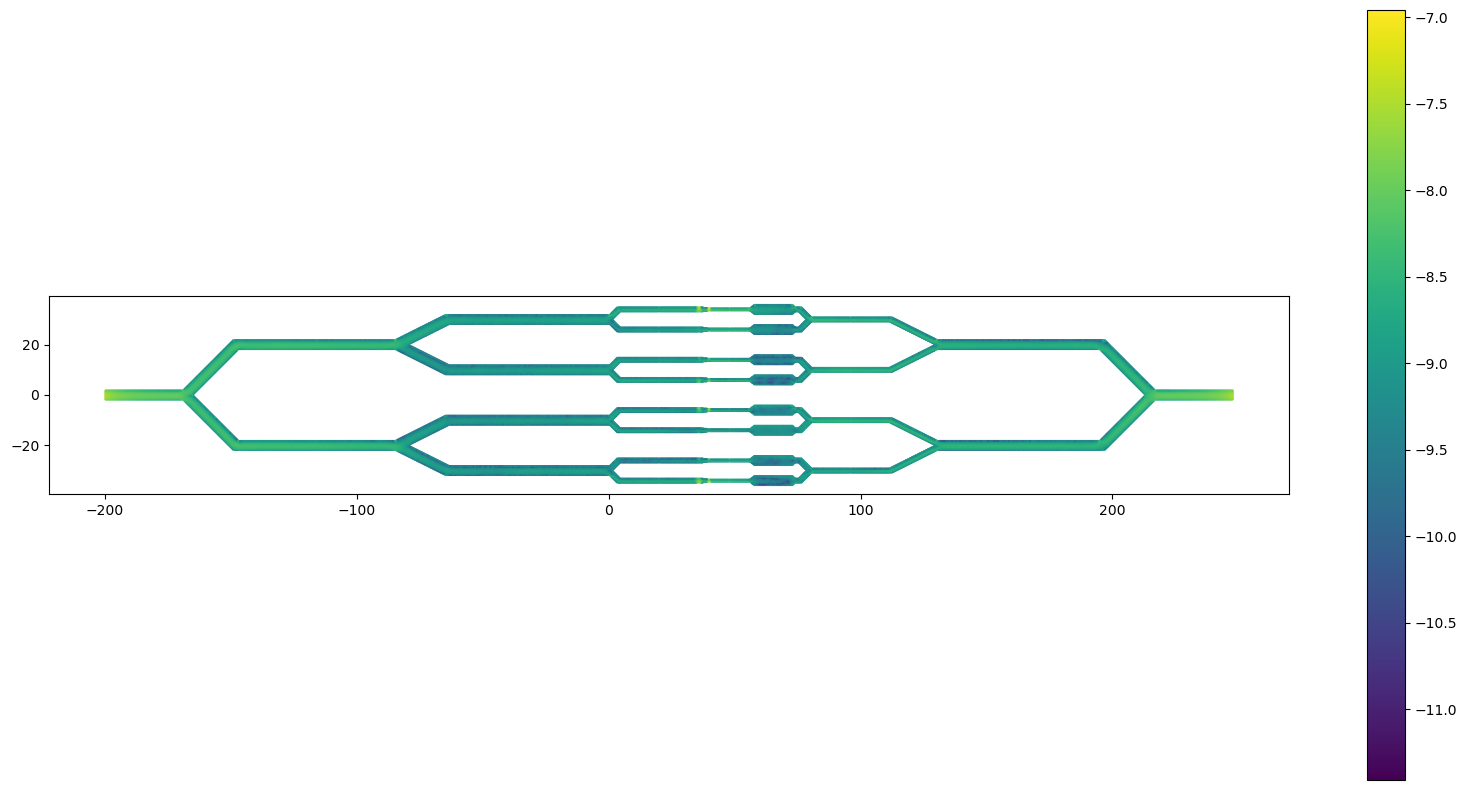

In [21]:
fig, ax = plt.subplots(figsize=(20,10))

ax.set_aspect('equal')
im = ax.scatter(xs,ys,c=np.log10((velocity[:,0] - u_field)**2 + (velocity[:,1] - v_field)**2)/2,s=0.1)
fig.colorbar(im)

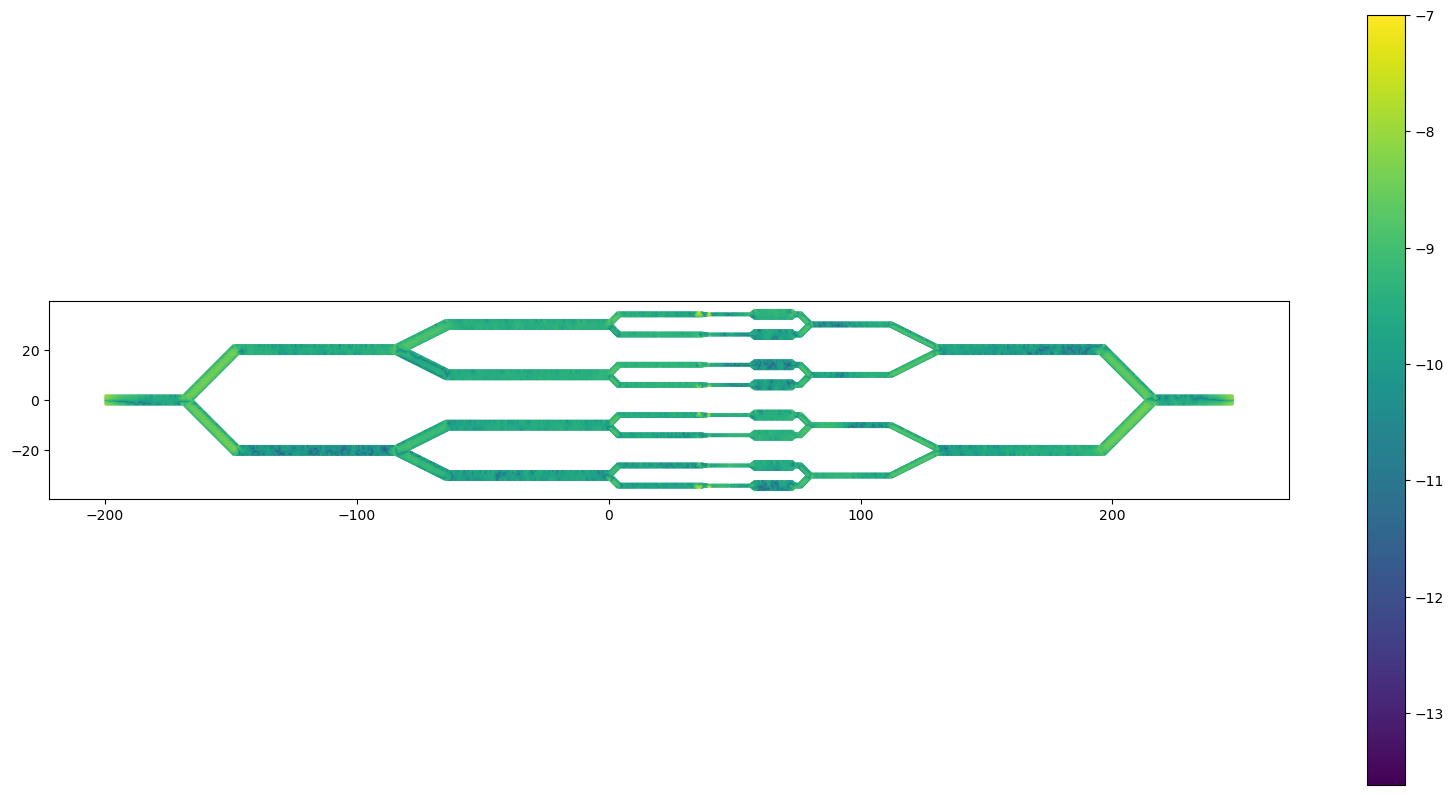

In [20]:
fig, ax = plt.subplots(figsize=(20,10))

ax.set_aspect('equal')
im = ax.scatter(xs,ys,c=np.log10(np.abs(velocity[:,1] - v_field)),s=0.1,vmax=-7)
fig.colorbar(im)